# Painting by Numbers 
The point of this document is to serve as an introduction into geospatial analytics using Python's `geopandas`.

For now, we start by painting the State of Texas Red, White, and Blue.

![](texas_rwb.png)

It is assumed that the reader has jupyterlab installed, along with the following packages:

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

First, download the zipcode geojson [alshival/State-zip-code-GeoJSON](https://raw.githubusercontent.com/alshival/State-zip-code-GeoJSON/master/tx_texas_zip_codes_geo.min.json), a project I forked originally from [Open Data Delaware](https://github.com/OpenDataDE). 

In [2]:
zipcodes = gpd.read_file('tx_texas_zip_codes_geo.min.json')
zipcodes.head(3)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,48,75801,4875801,B5,G6350,S,555807428,6484251,+31.7345202,-095.5313809,N,"POLYGON ((-95.68072 31.72800, -95.68085 31.728..."
1,48,75839,4875839,B5,G6350,S,381863557,3928555,+31.6066930,-095.5833403,N,"POLYGON ((-95.66269 31.64586, -95.66242 31.645..."
2,48,78336,4878336,B5,G6350,S,126923194,31624523,+27.9269126,-097.1777757,N,"POLYGON ((-97.19642 27.91194, -97.19618 27.912..."


Here is that plotted using `Matplotlib`

<Axes: >

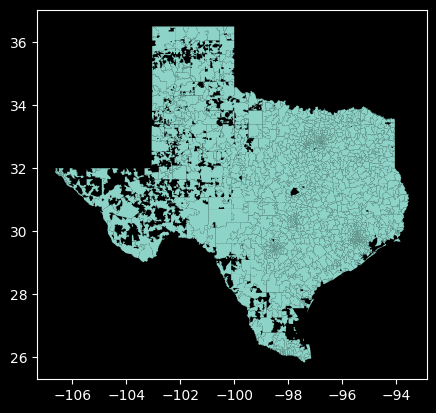

In [3]:
p = zipcodes.plot()
p

We want to color this map Red, White, and Blue. Let's choose two random $(x,y)$ coordinates on this grid to form a line heading from south west to north east.

First, let's get the domain and range of this xy-coordinates above, rounded to the nearest whole number:

In [4]:
zipcodes.geometry.total_bounds

array([-106.645646,   25.837164,  -93.508039,   36.500704])

The above gives us the bounds of the plot for texas. Let's take the Southwest corner as `(-107,25)`, and the Northwest corner is the point `(-93,37)`.

In order to plot our boundaries, we'll take 100 points evenly spaced within the domain `[-107,-93]`:

In [5]:
x = np.linspace(-107,-93,100)

We are going to divide the state of texas into three parts, one for each color `Red, White, Blue`. Let us start by drawing a line to show where the boundary of the first division will pass through.

I can get creative with the function that is used to define the boundary, but for now, let us stick with a linear function $f(x) = m\cdot x + b$.

Let's take these two points on the grid: 
    $p_1 = (-98,34)$,
    $p_2 = (-103,30)$.

In [6]:
p1 = {'x':-98,'y':34}
p2 = {'x':-103,'y':30}

Recall that the slope of a line passing through two points is $$m = \frac{y_2-y_1}{x_2-x_1}.$$

In [7]:
m = (p1['y']-p2['y']) / (p1['x']-p2['x'])
m

0.8

Now, the line defining our first boundary will be $f(x) - y_1 = m(x - x_1)$:

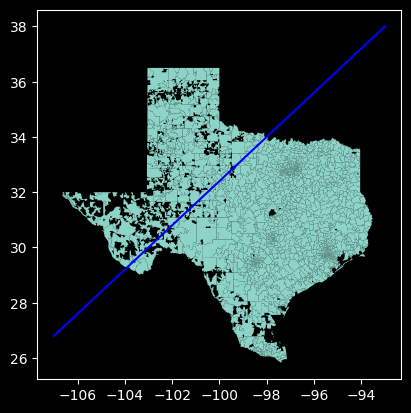

In [8]:
def f(x):
    y = m*(x - p1['x']) + p1['y']
    return y

f1 = list(map(f,x))

zipcodes.plot()
plt.plot(x, f1, '-b')

For the second boundary, we'll just move the first boundary down a bit.

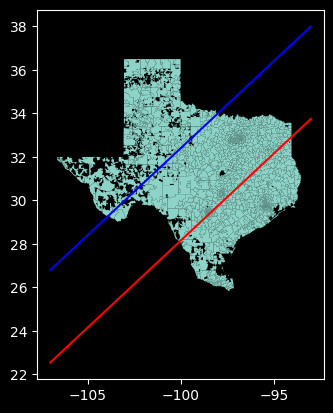

In [9]:
def g(x):
    y = m*(x - p2['x']) + p2['y'] - 4.25
    return y

g1 = list(map(g,x))

zipcodes.plot()
plt.plot(x, f1, '-b')
plt.plot(x, g1, '-r')

To color this map red, white, and blue, we need to determine which areas the zipcodes fall in. There are lots of ways to do this.

First, the geometry data contained within the geojson is polygonal. Let's start by calculating the center of each zip code. This is called the **[centroid](https://en.wikipedia.org/wiki/Centroid)** of the polygon.

In [10]:
#zipcodes['geometry'] = zipcodes['geometry'].to_crs(4326)
zipcodes['zipcode_centers']=zipcodes.to_crs('+proj=cea').centroid.to_crs(zipcodes.crs)

Any polygon whose centroid falls below the red line will be colored red. Anything above the blue line will be colored blue. Anything else will be colored white.

In [11]:
def bin(p):
    if p.y < g(p.x):
        return 'red'
    elif p.y > f(p.x):
        return 'blue'
    else:
        return 'white'
    
zipcodes['color'] = list(map(bin,zipcodes.zipcode_centers))

Finally, we make the plot.

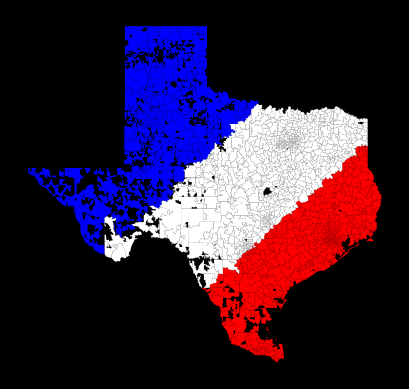

In [12]:
fig, ax = plt.subplots()

plt.axis('off')

grouped = zipcodes.groupby('color')
for key, group in grouped:
    group.plot(ax=ax, label=key, color=key)

# save plot to file
plt.savefig('texas_rwb.png')
plt.savefig('texas_rwb_transparent.png',transparent=True)
plt.show()